In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import keras as keras
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import roc_auc_score

import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

Using TensorFlow backend.


In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [4]:
print(keras.__version__)  # 2.2.4
print(tf.__version__)  # 1.15.0

2.2.4
1.15.0


# The SRGN fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at generator-level (before detector simulation) while the fit happens in simulation (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at simulation-level or both happen at generator-level.  This notebook illustrates the alternative SRGN procedure from (*insert link here*):

Let $x$ and $y$ denote the generator- and simulation-level events respectively. Suppose that $g$ is a neural network defined as follows:

$g_{\theta'}(y)=\text{argmax}_{g}\sum_{y_i\in\boldsymbol{\theta_?}}\log(g_{\theta'}(y_i))+
    \sum_{(x_i,y_i)\in\boldsymbol{\theta_0}}w(x_i,\theta',\theta_0)\log(1-g_{\theta'}(y_i))$

where $w(x,\theta',\theta_0) = f(x,\theta')/(1-f(x,\theta'))$ is a reweighting function learned at generator level (and $\theta_0$ denotes the nominal value of the parameter).  

Then, 

$\theta_{\text{SRGN}}^*\equiv\text{argmin}_{\theta'}\left[\Pr(g_{\theta_?}(y)>g_{\theta'}(y))\right]$

where the quantity in $[\cdot]$ is typically called the area under the receiver operating characteristic curve or AUC. We calculate the AUC between $g$’s predictions on events from the unknown sample and  $g$’s predictions on reweighted events from the synthetic sample; effectively, if we reweight events from the synthetic sample $\boldsymbol{\theta_0}$ to events from $\boldsymbol{\theta’}$, then we calculate the AUC between $g$’s predictions on  $\boldsymbol{\theta_?} $and $g$’s predictions on $\boldsymbol{\theta’}$.


The intuition of the above equation is that the classifier $g$ is trying to distinguish events from the unknown sample $\boldsymbol{\theta_?}$ and events from $\boldsymbol{\theta'}$ and we try to find a $\theta'$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples (i.e. the AUC is minimized), then the reweighting has worked! Asympotitically, the SRGN method learns the same result as the one in the body of the DCTR paper: $\theta^*=\theta_?$.

# Parton Shower Monte Carlo Tuning: probStoUD

In this notebook, we apply the SRGN fitting algorithm to the parton shower example from the original DCTR paper. Specifically, we attempt to tune the Monte Carlo parameter StringFlav:probStoUD (denoted probStoUD).

In [5]:
# Path to downloaded data from Zenodo
data_dir = '/data0/users/aandreassen/zenodo/'

### Utilities

In [6]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:, 0] > 0
    yphi_avg = np.average(x[mask, 1:3], weights=x[mask, 0], axis=0)
    x[mask, 1:3] -= yphi_avg
    x[mask, 0] /= x[:, 0].sum()

In [7]:
def preprocess_data(X):
    for x in X:
        normalize(x)

    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

## Training a DCTR Model
First, we need to train a DCTR model parameterized by probStoUD to provide us with a reweighting function to be used during fitting.

### Load training & validation data

In [8]:
# Load training data
dataset = np.load(data_dir + '1D_probStoUD_train.npz')

X = dataset['X']
Y = dataset['Y']

X = preprocess_data(X)
Y = to_categorical(Y, num_classes=2)

X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.1, shuffle=True)

### Build Model

In [9]:
# network architecture parameters
Phi_sizes = (100, 100, 128)
F_sizes = (100, 100, 100)

dctr = PFN(input_dim=7, Phi_sizes=Phi_sizes, F_sizes=F_sizes, summary=False)

### Train Model

In [10]:
# Train model
earlystopping = keras.callbacks.EarlyStopping(patience=10,
                                              verbose=1,
                                              restore_best_weights=True)

dctr.fit(X_train,
         Y_train,
         epochs=100,
         batch_size=1000,
         validation_data=(X_val, Y_val),
         verbose=1,
         callbacks=[earlystopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1620000 samples, validate on 180000 samples
Epoch 1/100





1620000/1620000 [==============================] - 150s 93us/step - loss: 0.7005 - acc: 0.5066 - val_loss: 0.6930 - val_acc: 0.5107
Epoch 2/100
1620000/1620000 [==============================] - 151s 93us/step - loss: 0.6924 - acc: 0.5141 - val_loss: 0.6910 - val_acc: 0.5211
Epoch 3/100
1620000/1620000 [==============================] - 149s 92us/step - loss: 0.6911 - acc: 0.5211 - val_loss: 0.6902 - val_acc: 0.5264
Epoch 4/100
1620000/1620000 [==============================] - 151s 93us/step - loss: 0.6905 - acc: 0.5247 - val_loss: 0.6902 - val_acc: 0.5292
Epoch 5/100
1620000/1620000 [==============================] - 156s 96us/step - loss: 0.6902 - acc: 0.5265 - val_loss: 0.6897 - val_acc: 0.5296
Epoch 6/100
1620000/1620000 [==============================] - 150s 92us/step - loss: 0.6900 - acc: 0.5278 - val_loss: 0.6896

### Defining reweighting function

$w(x_i,\theta)=((f(x_i,\theta)/(1-f(x_i,\theta)))$

Takes generator-level event from the synthetic sample $\boldsymbol{\theta_0}$ and weights it to an event from $\boldsymbol{\theta}$.

In [11]:
def reweight(events, param):  #from NN (DCTR)
    theta_prime = [0.1365, 0.68, param]

    # zip theta_prime to each input particle (but not to the padded rows)
    # check if pT != 0 --> zip theta_prime
    concat_input_and_params = np.where(
        np.abs(events[..., 0]) > 0, np.ones_like(events[..., 0]),
        np.zeros_like(events[..., 0]))

    concat_input_and_params = theta_prime * np.stack([
        concat_input_and_params, concat_input_and_params,
        concat_input_and_params
    ],
                                                     axis=-1)

    model_inputs = np.concatenate([events, concat_input_and_params], -1)

    f = dctr.model.predict(model_inputs, batch_size=100000)
    weights = (f[:, 1]) / (f[:, 0])

    return weights

## Validate DCTR for $\text{probStoUD}=0.275$

In [12]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}
plot_style_1 = {'alpha': 0.5, 'density': True}

# Define labels for legends
label_0 = r'probStoUD=0.217'

label_1 = r'probStoUD=0.275'

pythia_text = r'\textsc{Pythia 8}' + '\n' + r'$e^+e^- \to Z \to $ dijets' + '\n' + r"anti-$k_{\mathrm{T}}$, $R=0.8$"


def make_legend(ax):
    leg = ax.legend(frameon=False)
    leg.set_title(pythia_text, prop={'size': 14})
    leg._legend_box.align = "left"
    plt.tight_layout()

In [13]:
test_dataset_0 = np.load(data_dir + 'test1D_default.npz')
test_dataset_1 = np.load(data_dir + 'test1D_probStoUD.npz')

X0_test = preprocess_data(test_dataset_0['jet'][:, :, :4])
X1_test = preprocess_data(test_dataset_1['jet'][:, :, :4])

In [14]:
weights = reweight(X0_test, 0.275)

/home/asuresh/.local/lib/python3.5/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "
/home/asuresh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log
/home/asuresh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log
/home/asuresh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log
/home/asuresh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log
/home/asuresh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in log
/home/asuresh/.local/lib/python3.5/site-packages/ipykernel_launche

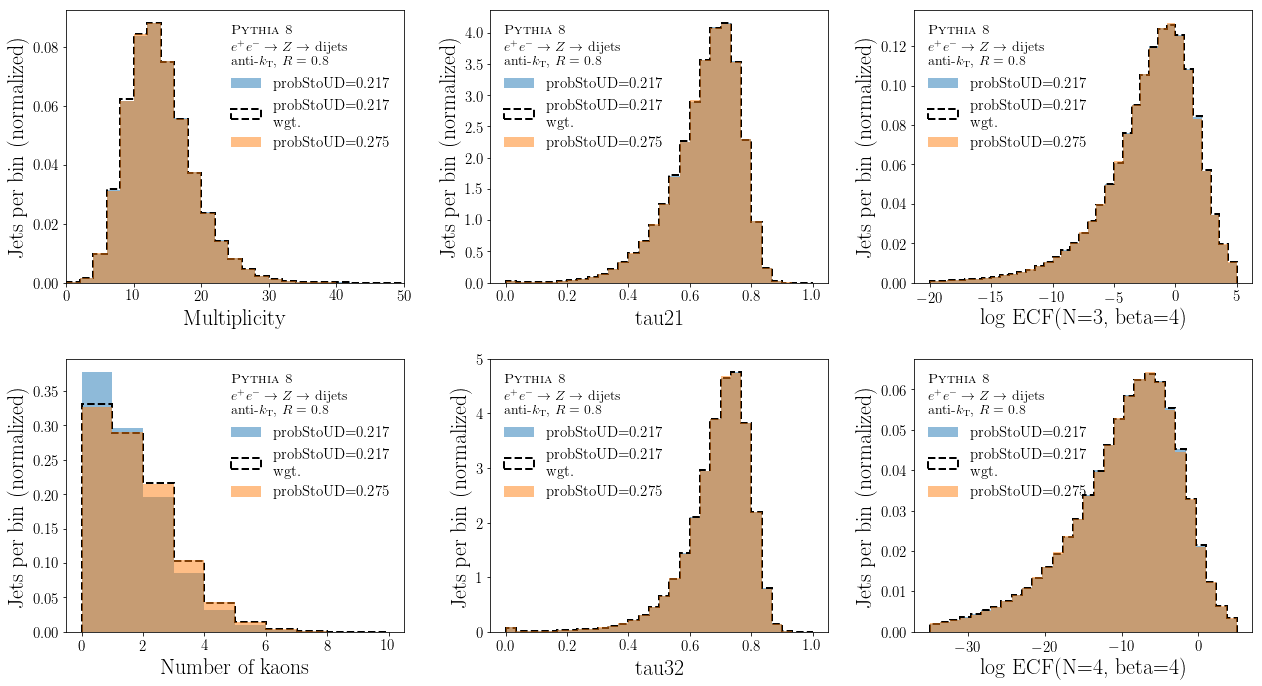

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)

bins = np.linspace(0, 50, 26)
ax[0, 0].hist(test_dataset_0['multiplicity'],
              bins=bins,
              label=label_0,
              **plot_style_1)
ax[0, 0].hist(test_dataset_0['multiplicity'],
              bins=bins,
              label=label_0 + '\nwgt.',
              weights=weights,
              **plot_style_0)
ax[0, 0].hist(test_dataset_1['multiplicity'],
              bins=bins,
              label=label_1,
              **plot_style_1)

ax[0, 0].set_xlabel('Multiplicity')
ax[0, 0].set_ylabel('Jets per bin (normalized)')
ax[0, 0].set_xlim([0, 50])
make_legend(ax[0, 0])

bins = np.linspace(0, 10, 11)
ax[1, 0].hist(test_dataset_0['number_of_kaons'],
              bins=bins,
              label=label_0,
              **plot_style_1)
ax[1, 0].hist(test_dataset_0['number_of_kaons'],
              bins=bins,
              label=label_0 + '\nwgt.',
              weights=weights,
              **plot_style_0)
ax[1, 0].hist(test_dataset_1['number_of_kaons'],
              bins=bins,
              label=label_1,
              **plot_style_1)

ax[1, 0].set_xlabel('Number of kaons')
ax[1, 0].set_ylabel('Jets per bin (normalized)')
make_legend(ax[1, 0])

bins = np.linspace(0, 1, 31)
ax[0, 1].hist(test_dataset_0['tau21'],
              bins=bins,
              label=label_0,
              **plot_style_1)
ax[0, 1].hist(test_dataset_0['tau21'],
              bins=bins,
              label=label_0 + '\nwgt.',
              weights=weights,
              **plot_style_0)
ax[0, 1].hist(test_dataset_1['tau21'],
              bins=bins,
              label=label_1,
              **plot_style_1)

ax[0, 1].set_xlabel('tau21')
ax[0, 1].set_ylabel('Jets per bin (normalized)')
make_legend(ax[0, 1])

bins = np.linspace(0, 1, 31)
ax[1, 1].hist(test_dataset_0['tau32'],
              bins=bins,
              label=label_0,
              **plot_style_1)
ax[1, 1].hist(test_dataset_0['tau32'],
              bins=bins,
              label=label_0 + '\nwgt.',
              weights=weights,
              **plot_style_0)
ax[1, 1].hist(test_dataset_1['tau32'],
              bins=bins,
              label=label_1,
              **plot_style_1)

ax[1, 1].set_xlabel('tau32')
ax[1, 1].set_ylabel('Jets per bin (normalized)')
make_legend(ax[1, 1])

bins = np.linspace(-20, 5, 36)
ax[0, 2].hist(np.log(test_dataset_0['ECF_N3_B4']),
              bins=bins,
              label=label_0,
              **plot_style_1)
ax[0, 2].hist(np.log(test_dataset_0['ECF_N3_B4']),
              bins=bins,
              label=label_0 + '\nwgt.',
              weights=weights,
              **plot_style_0)
ax[0, 2].hist(np.log(test_dataset_1['ECF_N3_B4']),
              bins=bins,
              label=label_1,
              **plot_style_1)

ax[0, 2].set_xlabel('log ECF(N=3, beta=4)')
ax[0, 2].set_ylabel('Jets per bin (normalized)')
make_legend(ax[0, 2])

bins = np.linspace(-35, 5, 31)
ax[1, 2].hist(np.log(test_dataset_0['ECF_N4_B4']),
              bins=bins,
              label=label_0,
              **plot_style_1)
ax[1, 2].hist(np.log(test_dataset_0['ECF_N4_B4']),
              bins=bins,
              label=label_0 + '\nwgt.',
              weights=weights,
              **plot_style_0)
ax[1, 2].hist(np.log(test_dataset_1['ECF_N4_B4']),
              bins=bins,
              label=label_1,
              **plot_style_1)

ax[1, 2].set_xlabel('log ECF(N=4, beta=4)')
ax[1, 2].set_ylabel('Jets per bin (normalized)')
make_legend(ax[1, 2])

# Fitting

## Setup the dataset

$\boldsymbol{\theta_0}$ denotes the synthetic sample used for reweighting, and we are trying to fit the parameter $\theta$ (in this case $\text{probStoUD}$) to the 'data' sample $\boldsymbol{\theta_?}$ ('theta_unknown').

In [16]:
theta0 = X0_test  # probStoUD=0.217
theta_unknown = X1_test  # probStoUD=0.275

labels0 = np.zeros_like(theta0[:, 0, 0])
labels_unknown = np.ones_like(theta_unknown[:, 0, 0])

In [17]:
xvals = np.concatenate((theta0, theta_unknown), axis=0)

yvals = np.concatenate((labels0, labels_unknown), axis=0)

In [18]:
X_train, X_test, Y_train, Y_test = data_split(xvals,
                                              yvals,
                                              test=0.5,
                                              shuffle=True)

## Fitting Model: Scan

We will show for fixed $\theta$, the AUC is minimized when $\theta=\theta_?$.

### Creating Model

In [19]:
model = PFN(input_dim=4,
            Phi_sizes=Phi_sizes,
            F_sizes=F_sizes,
            output_dim=1,
            output_act='sigmoid',
            summary=True)

batch_size = 1000
earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

# scanning range for theta
thetas = np.linspace(0.10, 0.30, 9)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_8 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_8[0][0]               
__________________________________________________________________________________________________
activation

We will train this model with a weighted binary cross-entropy loss function:

$\text{loss}(g_{\theta'}(x))=-\sum_{x_i\in\boldsymbol{\theta_?}}\log(g_{\theta'}(x_i))-
    \sum_{x_i\in\boldsymbol{\theta_0}}w(x_{i},\theta',\theta_0)\log(1-g_{\theta'}(x_i))$

### Scan with the Full Phase Space

In [20]:
def run_classifier(theta):

    weights_train = np.ones(len(X_train))
    weights_test = np.ones(len(X_test))

    # calculate weights for events in theta_0, but leave ones for events in theta_?
    weights_train[Y_train == 0] = reweight(events=X_train[Y_train == 0],
                                           param=theta)
    weights_test[Y_test == 0] = reweight(events=X_test[Y_test == 0],
                                         param=theta)

    model.model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

    # fit model on weighted binary cross-entropy
    history = model.fit(X_train,
                        Y_train,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(X_test, Y_test, weights_test),
                        sample_weight=weights_train,
                        verbose=0,
                        callbacks=[earlystopping])

    # after training, calculate AUC between unknown sample and reweighted synthetic sample
    auc = roc_auc_score(np.concatenate((Y_train, Y_test)),
                        model.predict(np.concatenate((X_train, X_test)),
                                      batch_size=100000),
                        sample_weight=np.concatenate(
                            (weights_train, weights_test)))

    return auc

In [21]:
AUC = []

for theta in thetas:
    print("Testing theta = {:.3f}".format(theta))

    auc = run_classifier(theta)
    AUC += [auc]

    print("AUC: {:.2f}".format(auc))
    print("\n")
    pass

Testing theta = 0.100
AUC: 0.63


Testing theta = 0.125
AUC: 0.61


Testing theta = 0.150
AUC: 0.60


Testing theta = 0.175
AUC: 0.58


Testing theta = 0.200
AUC: 0.56


Testing theta = 0.225
AUC: 0.54


Testing theta = 0.250
AUC: 0.52


Testing theta = 0.275
AUC: 0.51


Testing theta = 0.300
AUC: 0.52




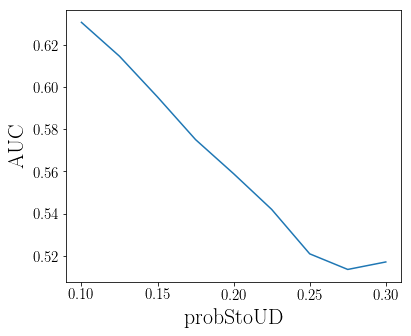

In [22]:
plt.figure(figsize=(6, 5))
plt.plot(thetas, AUC)
plt.xlabel(r'probStoUD')
plt.ylabel('AUC')
plt.show()

We've shown for fixed $\theta$, the AUC is minimized $\theta=\theta_?$ when scanning with the full phase space.

## Comparison to Fitting on $N_{\text{Strange Had.}}$ only

Let's compare fitting on the entire phase space to fitting only on the number of strange hadrons.  

In [23]:
K.clear_session()

### Training a DCTR Model
First, we need to train a DCTR model parameterized by $\text{probStoUD}$ that only receives $N_{\text{Strange Had.}}$ as an input to provide us with a reweighting function to be used during fitting.

#### Generate training & validation data

In [24]:
X = dataset['X']

Y = dataset['Y']
Y = to_categorical(Y, num_classes=2)

# strange hadrons particle IDs
strange_PIDs = np.array([130, 310, 311, 321, 3122, 3222, 3212, 3112])

# add anti-particles
strange_PIDs = np.concatenate([strange_PIDs,-strange_PIDs])

X_strange_had = []

for event in X:
    probStoUD = event[0][6]
    PIDs = event[:, 3]
    number_strange_hadrons = 0
    for PID in PIDs:
        number_strange_hadrons += PID in strange_PIDs
    X_strange_had.append([number_strange_hadrons, probStoUD])
    
X_strange_had = np.array(X_strange_had)

In [25]:
X_train, X_val, Y_train, Y_val = data_split(X_strange_had, 
                                            Y, 
                                            test=0.2, 
                                            shuffle=True)

#### Build Model

In [26]:
inputs = Input((2, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr = Model(inputs=inputs, outputs=outputs)
dctr.compile(loss='categorical_crossentropy', optimizer='Adam')

#### Train Model

In [27]:
earlystopping = EarlyStopping(patience=10,
                              restore_best_weights=True,
                              verbose=1)
dctr.fit(X_train,
         Y_train,
         epochs=200,
         batch_size=10000,
         validation_data=(X_val, Y_val),
         verbose=1,
         callbacks=[earlystopping])

Train on 1440000 samples, validate on 360000 samples
Epoch 1/200
1440000/1440000 [==============================] - 3s 2us/step - loss: 0.6916 - val_loss: 0.6908
Epoch 2/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6903 - val_loss: 0.6904
Epoch 3/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6900 - val_loss: 0.6903
Epoch 4/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6898 - val_loss: 0.6898
Epoch 5/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6897 - val_loss: 0.6898
Epoch 6/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6897 - val_loss: 0.6898
Epoch 7/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6897 - val_loss: 0.6898
Epoch 8/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6896 - val_loss: 0.6898
Epoch 9/200
1440000/1440000 [==============================] - 2s 2us/step 

#### Defining reweighting function

$w(x_i,\theta)=((f(x_i,\theta)/(1-f(x_i,\theta)))$

Takes generator-level event from the synthetic sample $\boldsymbol{\theta_0}$ and weights it to an event from $\boldsymbol{\theta}$.

In [28]:
def reweight(events, param):
    concat_input_and_params = np.ones(shape=events.shape) * param
    model_inputs = np.concatenate((events, concat_input_and_params), axis=-1)

    f = dctr.predict(model_inputs, batch_size=10000)
    weights = (f[:, 1]) / (f[:, 0])

    return weights

### Fitting

#### Setup the Dataset

In [29]:
theta0_jet = test_dataset_0['jet']
theta0 = []
for event in theta0_jet:
    PIDs = event[:, 3]
    number_strange_hadrons = 0
    for PID in PIDs:
        number_strange_hadrons += PID in strange_PIDs
    theta0 += [number_strange_hadrons]
theta0 = np.array(theta0)

theta_unknown_jet = test_dataset_1['jet']
theta_unknown = []
for event in theta_unknown_jet:
    PIDs = event[:, 3]
    number_strange_hadrons = 0
    for PID in PIDs:
        number_strange_hadrons += PID in strange_PIDs
    theta_unknown += [number_strange_hadrons]
theta_unknown = np.array(theta_unknown)

labels0 = np.zeros(len(theta0))
labels_unknown = np.ones(len(theta_unknown))

xvals = np.concatenate([theta0, theta_unknown])
yvals = np.concatenate([labels0, labels_unknown])

X_train, X_test, y_train, y_test = data_split(xvals,
                                              yvals,
                                              test=0.5,
                                              shuffle=True)

#### Fitting Model: Scan

##### Creating Model

In [30]:
myinputs = Input(shape=(1, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model = Model(inputs=myinputs, outputs=predictions)
model.summary()

batch_size = 1000
earlystopping = EarlyStopping(patience=10, restore_best_weights=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


##### Scan with $N_{\text{Strange Had.}}$ only

Again, we will train this model with a weighted binary cross-entropy loss function:

$\text{loss}(g_{\theta'}(x))=-\sum_{x_i\in\boldsymbol{\theta_?}}\log(g_{\theta'}(x_i))-
    \sum_{x_i\in\boldsymbol{\theta_0}}w(x_{i},\theta',\theta_0)\log(1-g_{\theta'}(x_i))$

In [31]:
def run_classifier(theta):

    weights_train = np.ones(len(X_train))
    weights_test = np.ones(len(X_test))

    # calculate weights for events in theta_0, but leave ones for events in theta_?
    weights_train[y_train == 0] = reweight(
        np.expand_dims(X_train[y_train == 0], axis=-1), theta)
    weights_test[y_test == 0] = reweight(
        np.expand_dims(X_test[y_test == 0], axis=-1), theta)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # fit model on weighted binary cross-entropy
    history = model.fit(X_train,
                        y_train,
                        sample_weight=weights_train,
                        epochs=1000,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test, weights_test),
                        verbose=0,
                        callbacks=[earlystopping])

    # after training, calculate AUC between unknown sample and reweighted synthetic sample
    auc = roc_auc_score(np.concatenate((y_train, y_test)),
                        model.predict(np.concatenate((X_train, X_test)),
                                      batch_size=10000),
                        sample_weight=np.concatenate(
                            (weights_train, weights_test)))

    return auc

In [32]:
AUC_strange_had = []

for theta in thetas:
    print("Testing theta = {:.3f}".format(theta))

    auc = run_classifier(theta)
    AUC_strange_had += [auc]

    print("AUC: {:.2f}".format(auc))
    print("\n")
    pass

Testing theta = 0.100
AUC: 0.62


Testing theta = 0.125
AUC: 0.61


Testing theta = 0.150
AUC: 0.58


Testing theta = 0.175
AUC: 0.56


Testing theta = 0.200
AUC: 0.55


Testing theta = 0.225
AUC: 0.53


Testing theta = 0.250
AUC: 0.51


Testing theta = 0.275
AUC: 0.50


Testing theta = 0.300
AUC: 0.51




##### Scan Results

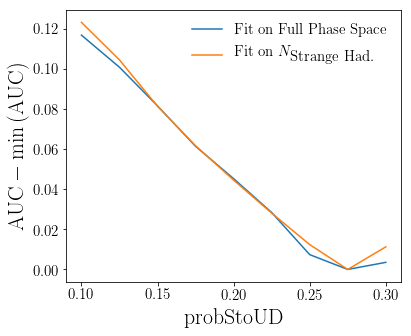

In [33]:
plt.figure(figsize=(6, 5))
plt.plot(thetas, (AUC - min(AUC)), label="Fit on Full Phase Space")
plt.plot(thetas, (AUC_strange_had - min(AUC_strange_had)), label=r"Fit on $N_{\textnormal{Strange Had.}}$")
plt.xlabel(r'probStoUD')
plt.ylabel(r'$\textnormal{AUC} - \min{\textnormal{(AUC)}}$')
plt.legend(frameon=False)
plt.show()

Even when scanning only on the number of strange hadrons, a simple one dimensional feature, we've shown for fixed $\theta$, the AUC is minimized $\theta=\theta_?$. Note that the rise in the AUC function away from the minimum is comparable between scanning with the full phase space and scanning with only with the number of strange hadrons; this is expected, since probStoUD primarily affects the number of strange particles in the event while leaving the rest of the phase space untouched, the full phase space does not offer much more information than the number of strange hadrons.